# Segment Regridded ICON Data

## Load Libraries 

In [1]:
import sys, os

import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pandas as pd

import scipy.ndimage
import seaborn as sns
#sns.set_context('talk')

In [2]:
from dask.diagnostics import ProgressBar

## Arguments

In [3]:
if 'ipykernel_launcher' in sys.argv[0]:
    interactive = True
    time_str = '20200601'
else:
    interactive = False
    time_str = sys.argv[1]

## Open Data 

In [4]:
indir = '/work/bb1368/b381642/experiments/r2b9_lite_1224b_post/005deg'
fname = f'{indir}/r2b9_lite_1224b_atm_2d_vid_ml_{time_str}T000000Z.nc'

In [5]:
dataset = xr.open_dataset( fname, chunks = 'auto' )

initial_varlist = list( dataset.data_vars )

## Prepare Data 

In [6]:
dataset['rain_tot_rate'] = 3600 * 24 * ( dataset['pr'] )  # unit convetion to mm day-1

dataset['rain_tot_rate'].attrs['units'] = 'mm day-1'

dataset['rain_tot_rate'].attrs['long_name'] = 'rain rate'


In [7]:
dataset['cwp'] = dataset['clivi'] + dataset['cllvi']

dataset['cwp'].attrs['units'] = 'kg m-2'

dataset['cwp'].attrs['long_name'] = 'cloud water path'


In [8]:
dataset['OLR'] = dataset['rlut']

dataset['OLR'].attrs['units'] = 'W m-2'

dataset['OLR'].attrs['long_name'] = 'outgoing longwave radiation'


In [9]:
d0  = dataset.isel(time = [0,], lon = slice(0,None, 4))

## Plot Latitudinal Distributions

In [10]:
dm = d0.mean(('lon',))

In [11]:
with ProgressBar():
    dm.compute()

[########################################] | 100% Completed | 26.44 s


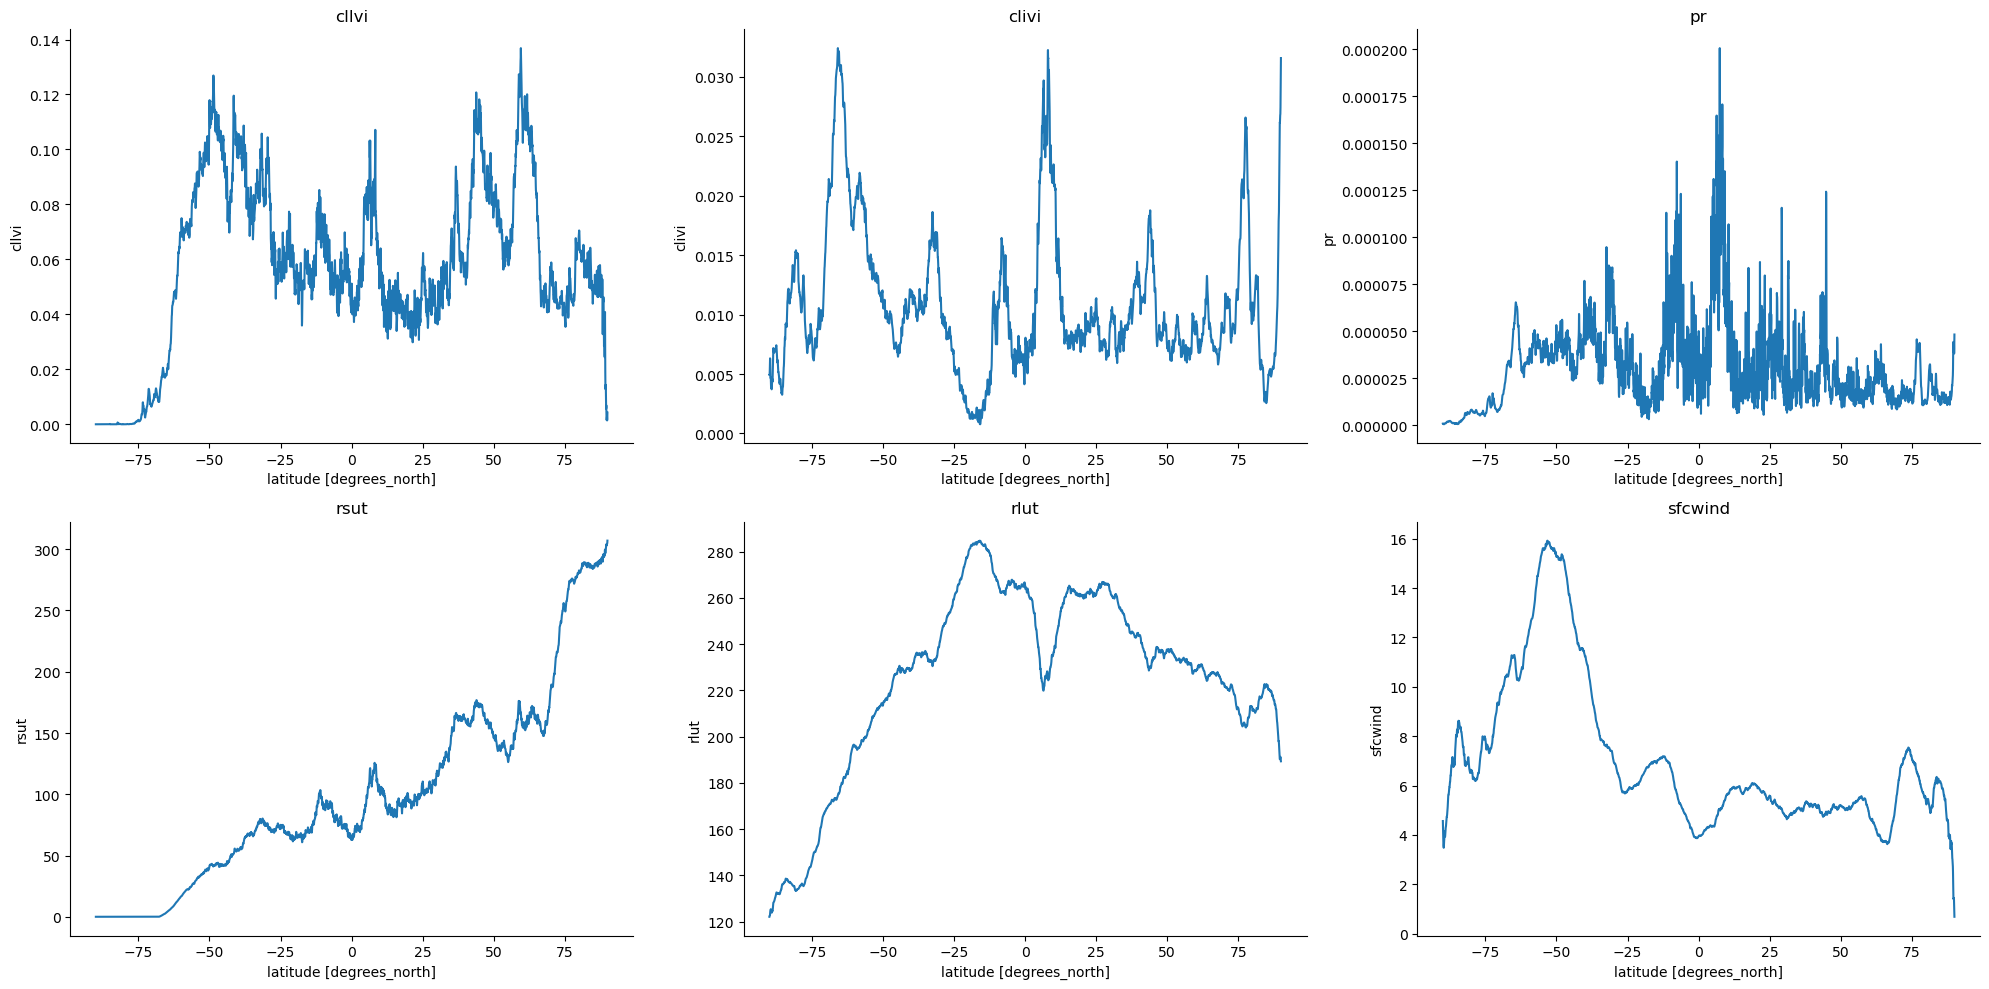

In [12]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (20,10))
axs = axs.flatten()

for i, vname in enumerate(initial_varlist):
    v = dm[vname]
    v.plot(x = 'lat', ax = axs[i])
    axs[i].set_title(vname)
sns.despine()
plt.tight_layout()

## Overview Maps 

In [13]:
vlist = ['cllvi', 'clivi', 'OLR', 'rain_tot_rate']

d0 = d0[vlist]
d0.load()

<xarray.Dataset> Size: 104MB
Dimensions:        (time: 1, lat: 3600, lon: 1800)
Coordinates:
  * time           (time) datetime64[ns] 8B 2020-06-01
  * lon            (lon) float64 14kB 0.0 0.2 0.4 0.6 ... 359.4 359.6 359.8
  * lat            (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
Data variables:
    cllvi          (time, lat, lon) float32 26MB 0.0 0.0 0.0 ... 0.00261 0.00261
    clivi          (time, lat, lon) float32 26MB 0.005483 0.005483 ... 0.03087
    OLR            (time, lat, lon) float32 26MB 121.7 121.7 ... 189.9 189.9
    rain_tot_rate  (time, lat, lon) float32 26MB 0.05384 0.05384 ... 4.178 4.178
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       git@gitlab.dkrz.de:icon/icon-mpim.git@b68de47df629c040ac081...
    institution:  Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title:        ICON simulation
    history:      Mon May 12 19:56:08 2025: cdo remap,r7200x3600,/work/bb1368...
    references:   see MPIM/DWD publications
    comment:      Philipp Weiss (b381642) on l50371 (Linux 4.18.0-513.24.1.el...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

### Tropical Belt

/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".


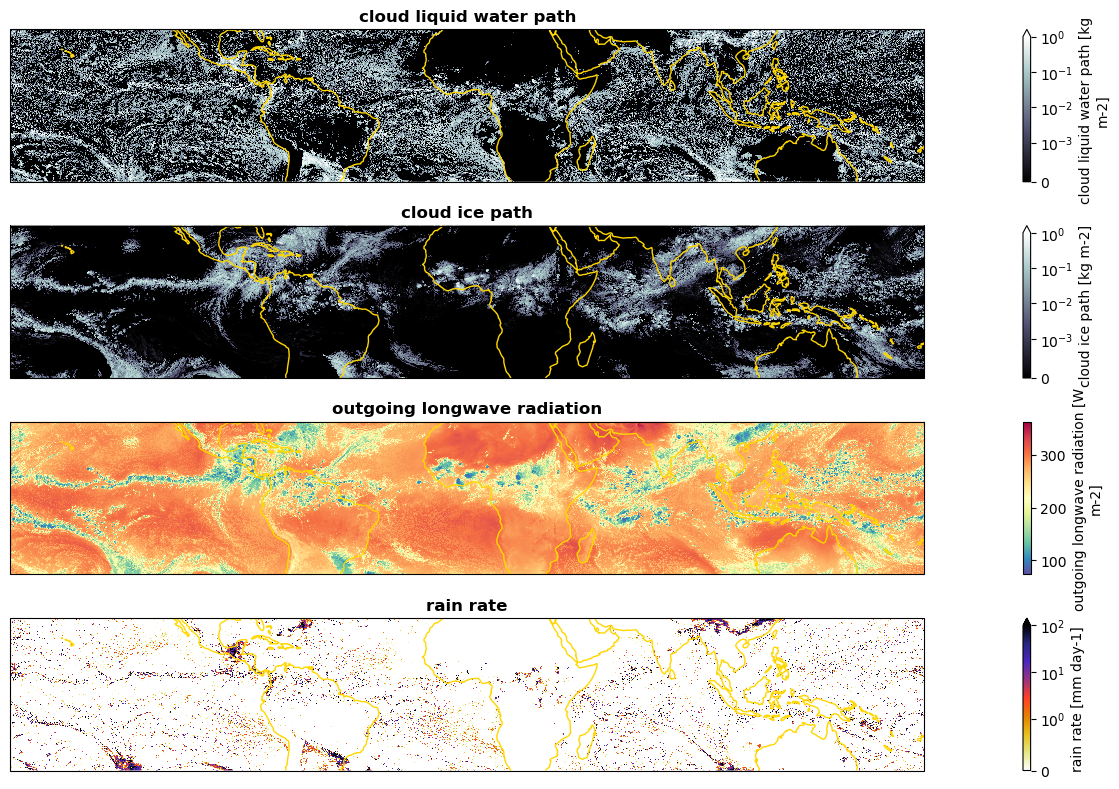

In [14]:
cmaps = [ 'bone', 'bone','Spectral_r','CMRmap_r' ]

LNc = plt.matplotlib.colors.SymLogNorm(linthresh = 1e-3, vmax= 1)
LNr = plt.matplotlib.colors.SymLogNorm(linthresh = 1, vmax= 100)
NN = plt.matplotlib.colors.Normalize()

norms = [LNc, LNc, NN, LNr]

target_map = ccrs.PlateCarree()
fig, axs = plt.subplots(ncols=1, nrows = 4, subplot_kw={'projection': target_map}, figsize = (20,8))
plt.subplots_adjust( wspace = 0.)
axs = axs.flatten()

for i, vname in enumerate( vlist ):
    a = axs[i]
    plt.sca(a)
    a.add_feature(cf.COASTLINE, color = 'gold')

    v = d0[vname]
    v.plot(    
        transform=ccrs.PlateCarree(),  # the data's projection
        subplot_kws={"projection": target_map},
        norm = norms[i],
        cmap=cmaps[i]
    )
    a.set_title( v.long_name, fontweight = 'bold' )
    a.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    
plt.tight_layout()

## Using tobac Feature Detection for Segmentation 

In [15]:
import tobac
tobac.__version__

'1.6.0'

## Variable Selection

In [16]:
RR = d0['rain_tot_rate']

### Lon/Lat 

In [17]:
dlon = d0.lon.diff('lon').mean().data
dlat = d0.lat.diff('lat').mean().data

lat0 = d0.lat.mean('lat').mean().data

### Equivalent Grid Size 

In [18]:
R_earth = 6371e3

dlambda = np.deg2rad( dlon )
dphi = np.deg2rad( dlat )
phi0 = np.deg2rad( lat0 )

dA = R_earth**2 * np.cos( phi0 ) * dlambda * dphi

dX = np.sqrt( dA )
print(dX)

11119.492664455873


In [19]:
dxy = dX

### Segmentation 

In [20]:
thresholds = [10,]#9,10] #np.arange(8,11)  )
print(thresholds)

# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=10  # mm/h mixing ratio


[10]


In [21]:
features = tobac.feature_detection_multithreshold(
    RR, dxy, thresholds, target="maximum", position_threshold="weighted_diff"
)

In [22]:
Mask_Precip,Features_Precip=tobac.segmentation_2D(features,RR,dxy,**parameters_segmentation)


/home/b/b380352/proj/2025-05_oxford-hackathon/tobac/tobac/segmentation/watershed_segmentation.py:1264: UserWarning: As of v1.6.0, segmentation with time length 1 will return time as a coordinate instead of dropping it (i.e., output will now be 1xMxN instead of MxN). 
  warnings.warn(


In [23]:
from tobac.utils import get_statistics_from_mask

In [24]:
statistics = {}
statistics['mean_precip'] = np.mean
statistics['total_precip'] = np.sum
statistics['max_precip'] = np.max
statistics['percentile95_precip'] = (np.percentile, {'q': 95})

In [25]:
features_with_stats = get_statistics_from_mask(Features_Precip, Mask_Precip, RR, statistic=statistics)

In [26]:
final_features = tobac.calculate_area(features_with_stats, Mask_Precip)

/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/iris/analysis/cartography.py:435: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [27]:
xfeat = final_features.to_xarray()



In [28]:
output_dir = '/work/bb1376/user/fabian/data/oxford-hackathon/icon-ham-light/precip_features_thresh50'

if not os.path.isdir( output_dir ):
    os.makedirs(output_dir)
    
outfile = f'{output_dir}/precip_features_thresh50_{time_str}.nc'

ff = xfeat.to_netcdf( outfile )

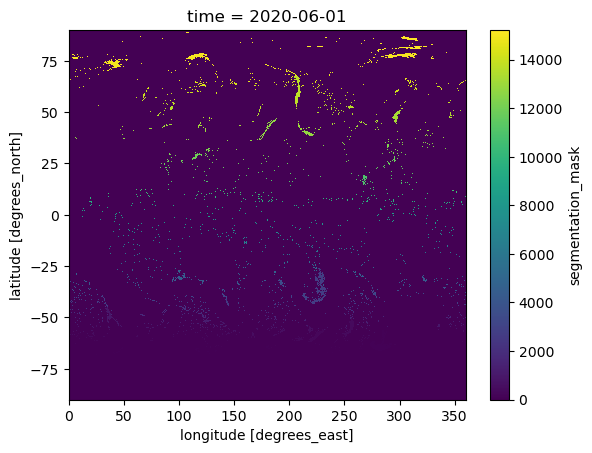

In [29]:
Mask_Precip.plot()

In [34]:
Mask_Precip.attrs['units'] = '-'

Mask_Precip.attrs['long_name'] = 'label mask'

d0['label_mask'] = Mask_Precip.where( Mask_Precip > 0 )

/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/b/b380352/proj/2025-05_oxford-hackathon/hackathon_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


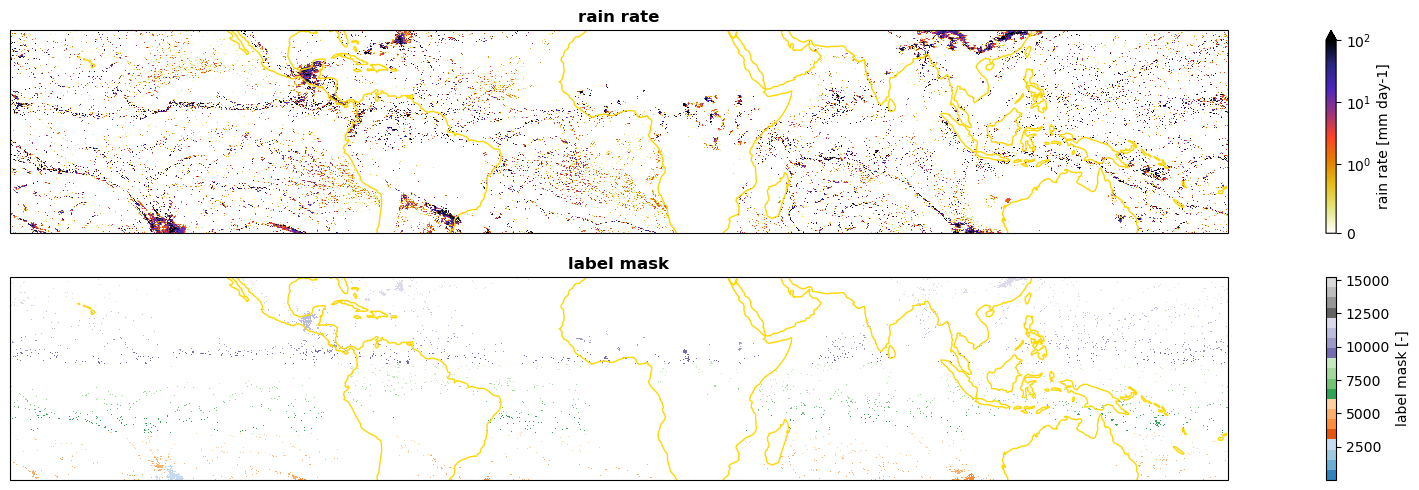

In [35]:
cmaps = [ 'CMRmap_r', 'tab20c' ]

LNr = plt.matplotlib.colors.SymLogNorm(linthresh = 1, vmax= 100)
NN = plt.matplotlib.colors.Normalize()

norms = [LNr, NN,]

target_map = ccrs.PlateCarree()
fig, axs = plt.subplots(ncols=1, nrows = 2, subplot_kw={'projection': target_map}, figsize = (20,5))
plt.subplots_adjust( wspace = 0.)
axs = axs.flatten()

vlist = [ 'rain_tot_rate', 'label_mask']
for i, vname in enumerate( vlist ):
    a = axs[i]
    plt.sca(a)
    a.add_feature(cf.COASTLINE, color = 'gold')

    v = d0[vname]
    v.plot(    
        transform=ccrs.PlateCarree(),  # the data's projection
        subplot_kws={"projection": target_map},
        norm = norms[i],
        cmap=cmaps[i]
    )
    a.set_title( v.long_name, fontweight = 'bold' )
    a.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    
plt.tight_layout()